In [166]:

import matplotlib as plt 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime
sns.set_style('whitegrid')
#remove error : TypeError: float() argument must be a string or a number, not 'Period'
plt.rcParams['font.sans-serif'] = "Georgia"
pd.plotting.register_matplotlib_converters()

In [12]:
#### LSTM 
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import itertools

In [13]:
#%% 
# convert series to supervised learning, i.e. lagged time-series is input, next value is target
def predict_optimize_LSTM(X_,n_predict, n_valid,n_testper, windows=range(3,4), lstmsizes=range(1,3),
                         trainepochs=35, testepochs=40):
    X_ = X_[:,np.newaxis]
    rmses=[]
    forecasts=[]
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    dataset = X_.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    for window,lstmsize in list(itertools.product(windows,lstmsizes)):
        # split into train and test sets
        train, test = dataset[:-n_predict-n_valid-window,:], dataset[-n_predict-n_valid-window:-n_predict-window,:]
        # reshape into X=t and Y=t+1
        look_back = window
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        # reshape input to be [samples, time steps, features]
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(lstmsize, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        _ = model.fit(trainX, trainY, epochs=trainepochs, batch_size=1, verbose=0)
        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])
        rmses.append(np.sqrt(np.sum( (testY[0] - testPredict[:,0])**2)))
    
 
    window, lstmsize  =  list(itertools.product(windows,lstmsizes))[np.argmin(rmses)]
    train, test = dataset[:-n_predict-window,:], dataset[-n_predict-window:,:]
    # reshape into X=t and Y=t+1
    look_back = window
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    testX = np.append(testX, np.array(dataset[-look_back-1:-1]).T,0)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(lstmsize, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    _ = model.fit(trainX, trainY, epochs=testepochs, batch_size=1, verbose=0)
    # make predictions
    testPredict = model.predict(testX)

    testPredict = scaler.inverse_transform(testPredict)
    return model, [window, lstmsize], testPredict
    # shift train predictions for plotting

In [652]:
#NY
df = pd.read_csv('new_york.csv')
df['Date'] = pd.to_datetime(df['Date'])

#converting data to daily usage.
df.index = df.Date
df = df.drop('Date', axis=1)
# resample the dataframe every 1 day (D) and sum ovr each day
df = df.resample('D').sum()
df = df.tz_localize(None)

df = df[:'2020-08-10']

In [653]:
mck_train = df[:-200]
mck_test = df[-200:]

In [654]:
mck_train.shape

(1668, 1)

In [625]:
mck_test.shape

(200, 1)

In [655]:
n_predict = 200
n_valid = 100
n_testper = 1  
X_in = np.append(mck_train,mck_test)

In [75]:
lstm, params, predictions = predict_optimize_LSTM(X_in,n_predict, n_valid,n_testper, 
                                              windows=range(20,30,1), lstmsizes=range(1,4),
                                                trainepochs=30, testepochs=40)

KeyboardInterrupt: 

In [61]:
'''
import pickle
with open('predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)
'''

In [370]:
import pickle
with open('predictions.pkl', 'rb') as f:
    predictions= pickle.load(f)

In [645]:
def plot_data(true,preds,dates,area, model, days=200,ax_var =4):
    fig, ax = plt.subplots(figsize=(25,6))
    plt.plot(dates,true, c='#ff5e15', linewidth=2,label='True')
    plt.plot(dates,preds, color='#5175bc',linewidth=1.2,label='Predicted')
    
    plt.title(f'Predicted Electricy Demand for 1 day(s) with {model} for {days} days for {area}',fontsize=25, pad=20)
   #           f'{str(arima_exog_model.order)}{str(arima_exog_model.seasonal_order)} ', fontsize=25, pad=20)
    plt.yticks(fontsize=13)
    plt.ylabel('Energy Demand in MWh', fontsize=20)
    plt.xlabel('Predicted Dates', fontsize=20)
    plt.legend(fontsize=12)    
    #plt.grid([])
    plt.xticks([dates[i] for i in range(1,len(dates),ax_var)] ,[dates[i].strftime('%Y-%m-%d') for i in range(1,len(dates),ax_var)],fontsize=13)
    plt.xticks(rotation=40)
    plt.xlim([dates[0]+1,dates[-1]+1])
    plt.show()
        

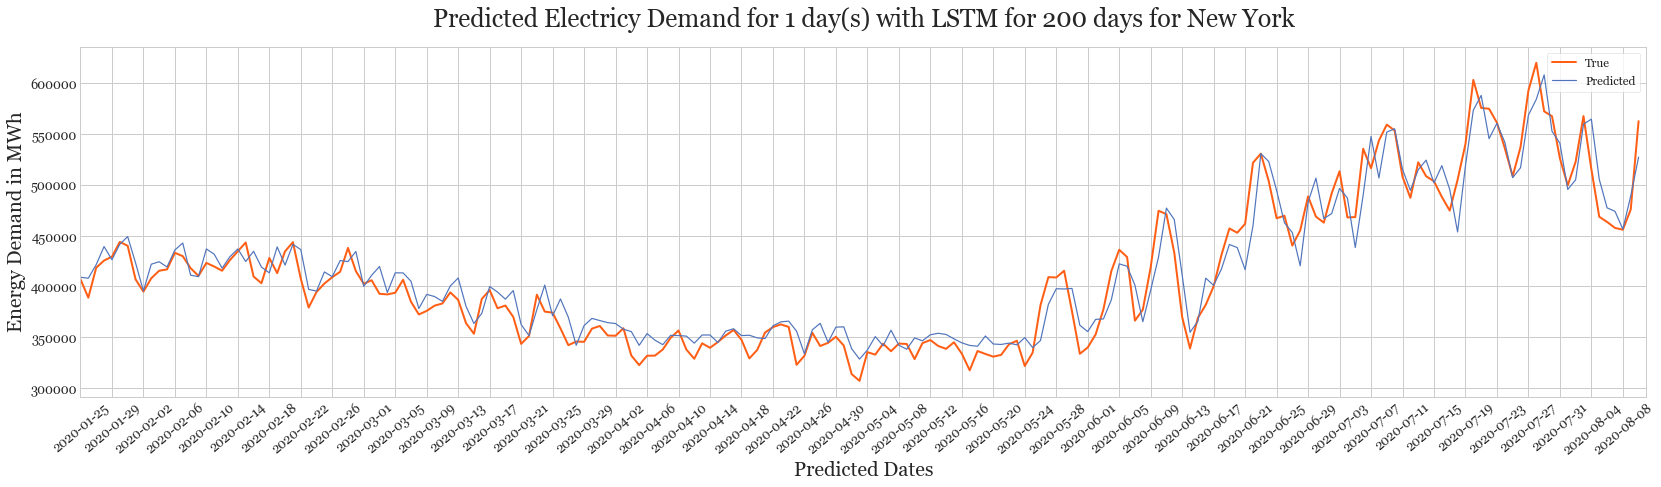

In [646]:
plot_data(X_in[-200:], predictions, df.index[-200:], 'New York','LSTM')

## Dilated CNN

In [546]:
"""
Keras implementation of Dilated Causal Convolutional Neural Network for Time 
Series Predictions based on the following sources:
[1] A. van den Oord et al., “Wavenet: A generative model for raw audio,” arXiv 
    preprint arXiv:1609.03499, 2016.
[2] A. Borovykh, S. Bohte, and C. W. Oosterlee, “Conditional Time Series 
    Forecastang with Convolutional Neural Networks,” arXiv:1703.04691 [stat], 
    Mar. 2017.
Initial 1D convolutional code structure based on:
https://gist.github.com/jkleint/1d878d0401b28b281eb75016ed29f2ee
Author: Krist Papadopoulos
V0 Date: March 31, 2018
V1 Data: September 12, 2018
         - updated Keras merge function to Add for Keras 2.2.2
        
         tensorflow==1.10.1
         Keras==2.2.2
         numpy==1.14.5
"""

from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv1D, Input, Add, Activation, Dropout

from keras.models import Sequential, Model

from keras.regularizers import l2

from keras.initializers import TruncatedNormal

from keras.layers.advanced_activations import LeakyReLU, ELU

from keras import optimizers


def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
    def f(input_):
        
        residual =    input_
        
        layer_out =   Conv1D(filters=nb_filter, kernel_size=filter_length, 
                      dilation_rate=dilation, 
                      activation='linear', padding='causal', use_bias=False,
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(input_)
                    
        layer_out =   Activation('selu')(layer_out)
        
        skip_out =    Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(layer_out)
        
        network_in =  Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(layer_out)
                      
        network_out = Add()([residual, network_in])
        
        return network_out, skip_out
    
    return f


def DC_CNN_Model(length):
    
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,2,32,0.001)(l5a)
    l6b = Dropout(0.8)(l6b) #dropout used to limit influence of earlier data
    l7a, l7b = DC_CNN_Block(32,2,64,0.001)(l6a)
    l7b = Dropout(0.8)(l7b) #dropout used to limit influence of earlier data

    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    
    l9 =   Activation('relu')(l8)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False, 
           kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
           kernel_regularizer=l2(0.001))(l9)

    model = Model(input=input, output=l21)
    
    """
    adam = optimizers.Adam(lr=0.00075, beta_1=0.9, beta_2=0.999, epsilon=None, 
                           decay=0.0, amsgrad=False)
    """
    adam = optimizers.Adam(lr=0.001)
    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    return model
 

def evaluate_timeseries(timeseries, predict_size, true):
    
    #true
    ts2 = true
    length2 = len(ts2)
    ts2=np.atleast_2d(np.asarray(ts2)).T.reshape(1,length2,1)

    # timeseries input is 1-D numpy array
    # forecast_size is the forecast horizon
    
    timeseries = timeseries[~pd.isna(timeseries)]

    length = len(timeseries)-1

    timeseries = np.atleast_2d(np.asarray(timeseries))
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T 

    model = DC_CNN_Model(length)
    print('\n\nModel with input size {}, output size {}'.
                                format(model.input_shape, model.output_shape))
    
    model.summary()

    X = timeseries[:-1].reshape(1,length,1)
    y = timeseries[1:].reshape(1,length,1)
    
    print(X)
    model.fit(X, y, epochs=3000, verbose=0)
    
    pred_array = np.zeros(predict_size).reshape(1,predict_size,1)
    X_test_initial = timeseries[1:].reshape(1,length,1)
    #pred_array = model.predict(X_test_initial) if predictions of training samples required
    
    #forecast is created by predicting next future value based on previous date
    pred_array[:,0,:] = model.predict(X_test_initial)[:,-1:,:]
    for i in range(predict_size-1):

        pred_array[:,i+1:,:] = model.predict(np.append(X_test_initial[:,i+1:,:], 
                               ts2[:,:i+1,:]).reshape(1,length,1))[:,-1:,:]
    
    return pred_array.flatten()





In [549]:
cnn_predicted_ny = evaluate_timeseries(df.Consumption[:-100], 31, df.Consumption[-100:-70] )



Model with input size (None, 1767, 1), output size (None, 1767, 1)
Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 1767, 1)      0                                            
__________________________________________________________________________________________________
conv1d_837 (Conv1D)             (None, 1767, 32)     64          input_39[0][0]                   
__________________________________________________________________________________________________
activation_305 (Activation)     (None, 1767, 32)     0           conv1d_837[0][0]                 
__________________________________________________________________________________________________
conv1d_839 (Conv1D)             (None, 1767, 1)      32          activation_305[0][0]             
______________________

## Compare SARIMAX vs LSTM vs CNN

In [150]:
with open('arima_errors.pkl', 'rb') as file:
    sarimax_errors= pickle.load(file)

In [225]:
#lstm errors
errors = [np.abs(X_in[-100:-70][i]-predictions[-100:-70][i]) for i in range(len(predictions[-100:-70]))]
LSTM_forecast_errors =  [forecast_errors[i][0] for i in range (len(forecast_errors))]

In [216]:
df[-100:-70].index
forecast_errors[0][0]

21440.28125

In [332]:
np.mean(sarimax_errors), np.mean(LSTM_forecast_errors)

(10769.82524728671, 13488.782291666666)

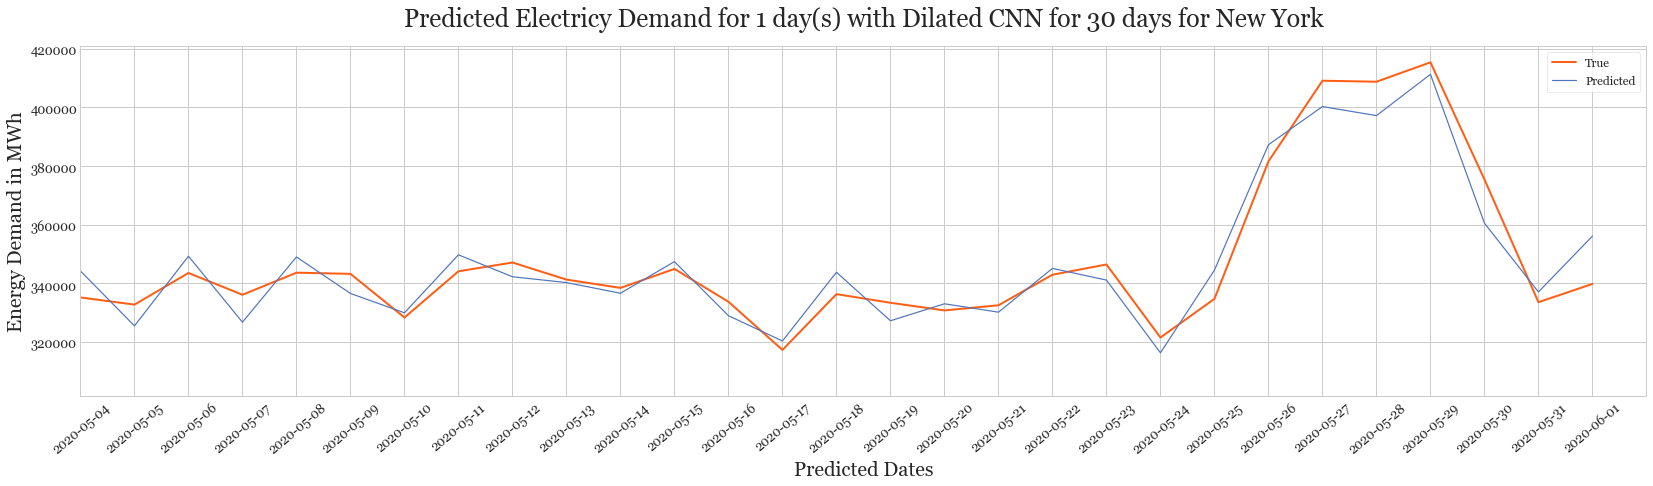

In [647]:

plot_data(df.Consumption[-100:-70].values,cnn_predicted_ny[1:],df.Consumption[-100:-70].index,'New York','Dilated CNN', days=30,ax_var =1)


In [586]:
#cnn errors

dicnn_predicted_ny = cnn_predicted_ny[1:]
dicnn_errors_ny = [np.abs(X_in[-100:-70][i]-dicnn_predicted_ny[i]) for i in range(len(predictions[-100:-70]))]

In [582]:
np.arange(len(bars1))

NameError: name 'bars1' is not defined

In [589]:
np.mean(dicnn_errors_ny)

6226.686458333334

In [595]:
[dates[i].strftime('%Y-%m-%d') for i in range(len(dates))]

['2020-05-03',
 '2020-05-04',
 '2020-05-05',
 '2020-05-06',
 '2020-05-07',
 '2020-05-08',
 '2020-05-09',
 '2020-05-10',
 '2020-05-11',
 '2020-05-12',
 '2020-05-13',
 '2020-05-14',
 '2020-05-15',
 '2020-05-16',
 '2020-05-17',
 '2020-05-18',
 '2020-05-19',
 '2020-05-20',
 '2020-05-21',
 '2020-05-22',
 '2020-05-23',
 '2020-05-24',
 '2020-05-25',
 '2020-05-26',
 '2020-05-27',
 '2020-05-28',
 '2020-05-29',
 '2020-05-30',
 '2020-05-31',
 '2020-06-01']

In [596]:
df[-100:-70].index

DatetimeIndex(['2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10',
               '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
               '2020-05-15', '2020-05-16', '2020-05-17', '2020-05-18',
               '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22',
               '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30',
               '2020-05-31', '2020-06-01'],
              dtype='datetime64[ns]', name='Date', freq='D')

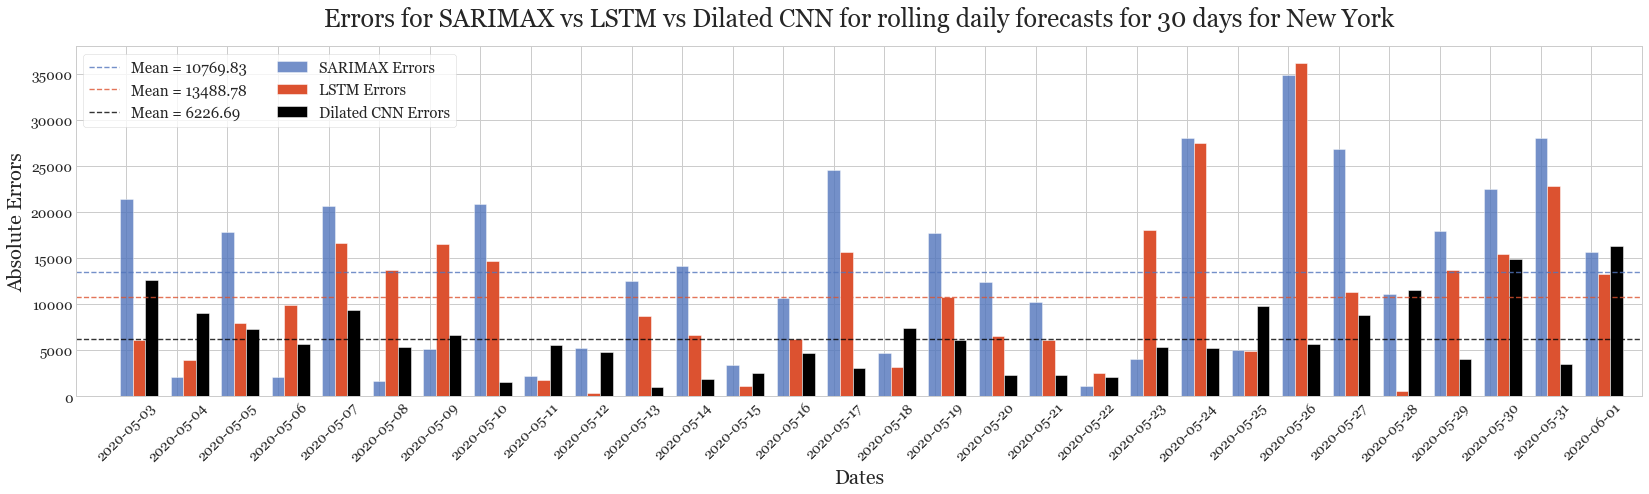

In [594]:

dates = df[-100:-70].index
barWidth = 0.25
r1 = np.arange(len(dates))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
               
fig = plt.figure(figsize=(25,6))
plt.title(f'Errors for SARIMAX vs LSTM vs Dilated CNN for rolling daily forecasts for 30 days for New York',fontsize=25, pad=20)       
plt.bar(r1, LSTM_forecast_errors, barWidth, color='#5175bc',alpha=0.8, label=f'SARIMAX Errors')
plt.bar(r2, sarimax_errors, barWidth,color='#DC5230', label=f'LSTM Errors' )
plt.bar(r3, dicnn_errors_ny, barWidth,color='black', label=f'Dilated CNN Errors' )
                            
_ = plt.xticks(indices, [dates[i].strftime('%Y-%m-%d') for i in range(len(dates))], rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Absolute Errors', fontsize=20)
plt.xlabel('Dates', fontsize=20)
_ = plt.xlim(-1,30)
plt.axhline(y=np.mean(LSTM_forecast_errors), color='#5175bc',alpha=0.8, lw=1.4, linestyle='--', label=f'Mean = {np.round(np.mean(sarimax_errors),2)}')
plt.axhline(y=np.mean(sarimax_errors), color='#DC5230', alpha=0.8, lw=1.4, linestyle='--', label =f'Mean = {np.round(np.mean(LSTM_forecast_errors),2)}')
plt.axhline(y=np.mean(dicnn_errors_ny), color='black', alpha=0.8, lw=1.4, linestyle='--', label =f'Mean = {np.round(np.mean(dicnn_errors_ny),2)}')

plt.legend(fontsize=15,ncol=2)

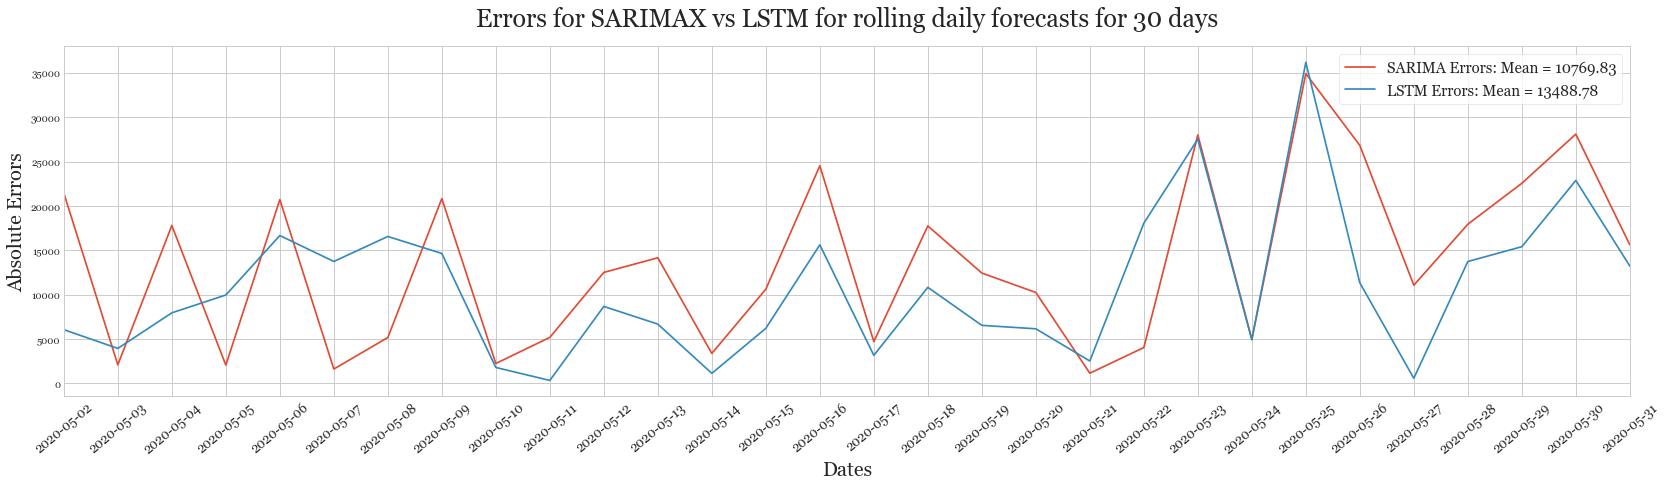

In [214]:
fig, ax = plt.subplots(figsize=(25,6))
plt.plot(df[-100:-70].index, forecast_errors, lw=1.7, label=f'SARIMA Errors: Mean = {np.round(np.mean(sarimax_errors),2)}')
plt.plot(df[-100:-70].index, sarimax_errors, lw=1.7, label=f'LSTM Errors: Mean = {np.round(np.mean(LSTM_forecast_errors),2)}')
dates = df[-100:-70].index
plt.xticks(dates,[dates[i].strftime('%Y-%m-%d') for i in range(len(dates))],fontsize=13)
plt.xticks(rotation=40)
plt.xlim([dates[0],dates[-1]])
plt.ylabel('Absolute Errors', fontsize=20)
plt.xlabel('Dates', fontsize=20)
plt.title(f'Errors for SARIMAX vs LSTM for rolling daily forecasts for 30 days',fontsize=25, pad=20)        
plt.legend(fontsize=15)

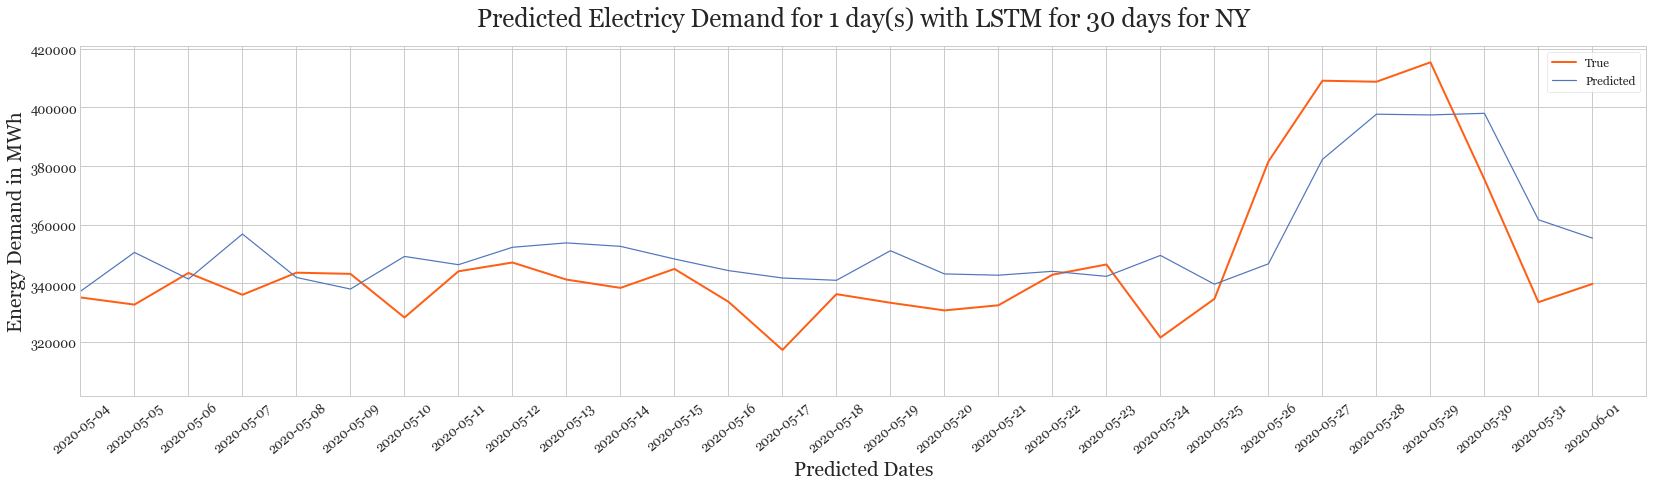

In [657]:
plot_data(X_in[-100:-70],predictions[-100:-70],df[-100:-70].index,'NY','LSTM', days=30, ax_var=1 )

# California

In [662]:

cali_df = pd.read_csv('california_sample.csv')
cali_df.columns = ['Date','Consumption']
cali_df['Date'] = pd.to_datetime(cali_df['Date'], utc=True)
cali_df.index = cali_df.Date
cali_df = cali_df.sort_index()


#converting data to daily usage.
cali_df = cali_df.drop('Date', axis=1)
# resample the dataframe every 1 day (D) and sum ovr each day
cali_df = cali_df.resample('D').sum()
cali_df = cali_df.tz_localize(None)
cali_df = cali_df[:'2020-08-10']
df=cali_df

In [663]:
mck_train = df[:-200]
mck_test = df[-200:]
n_predict = 200
n_valid = 100
n_testper = 1  
X_in = np.append(mck_train,mck_test)

In [335]:
lstm, params, predictions = predict_optimize_LSTM(X_in,n_predict, n_valid,n_testper, 
                                              windows=range(20,30,1), lstmsizes=range(1,4),
                                                trainepochs=30, testepochs=40)

KeyboardInterrupt: 

In [84]:
'''
with open('cali_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)
'''

"\nwith open('cali_predictions.pkl', 'wb') as f:\n    pickle.dump(predictions, f)\n"

In [376]:
with open('cali_predictions.pkl', 'rb') as f:
    cali_predictions= pickle.load(f)

In [377]:
with open('arima_errors_cali.pkl', 'rb') as f:
    cali_arima_errors= pickle.load(f)


In [378]:
cali_errors = [np.abs(X_in[-100:-70][i]-cali_predictions[-100:-70][i]) for i in range(len(cali_predictions[-100:-70]))]
cali_LSTM_forecast_errors =  [cali_errors[i][0] for i in range (len(forecast_errors))]

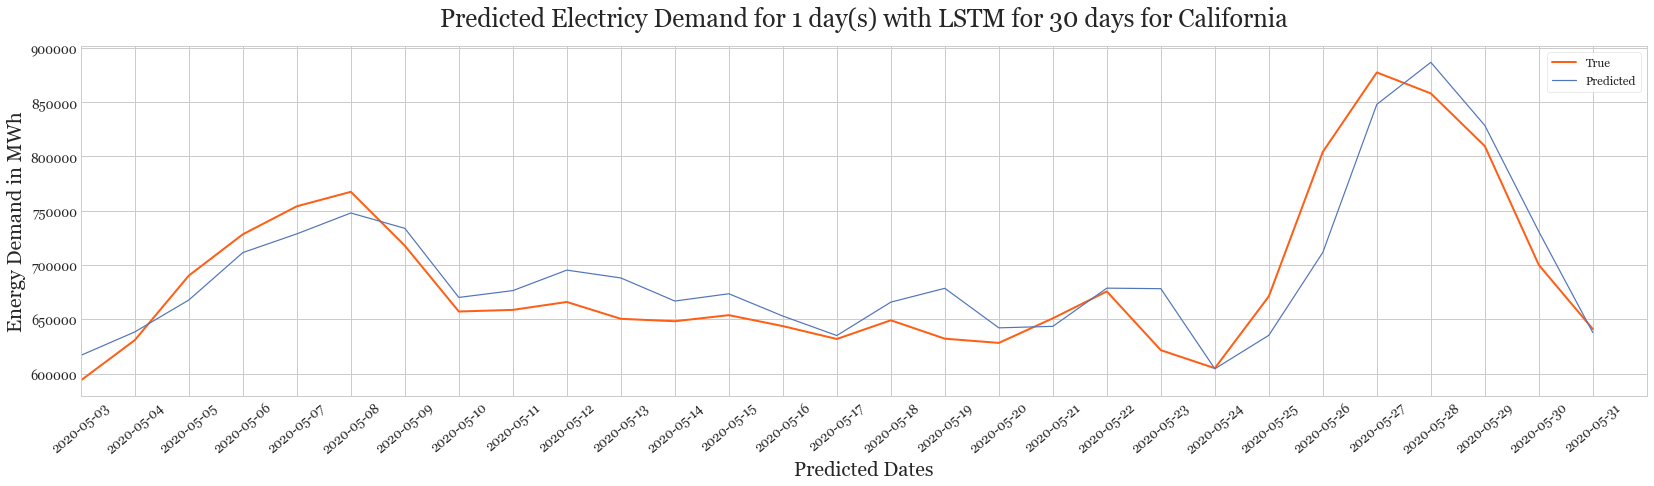

In [664]:
plot_data(X_in[-100:-70],cali_predictions[-100:-70],df[-100:-70].index, 'California', 'LSTM',days=30, ax_var=1)

In [494]:
df[-100:-70].index

DatetimeIndex(['2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05',
               '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09',
               '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13',
               '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17',
               '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
               '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29',
               '2020-05-30', '2020-05-31'],
              dtype='datetime64[ns]', name='Date', freq='D')

In [ ]:
# Dialated CNN
cnn_predicted_cali = evaluate_timeseries(df.Consumption[:-100], 31, df.Consumption[-100:-70] )



In [ ]:
ax_var =4

In [615]:
dicnn_predicted_cali = cnn_predicted_cali[1:]
dicnn_errors_cali = [np.abs(X_in[-100:-70][i]-dicnn_predicted_cali[i]) for i in range(len(dicnn_predicted_cali))]

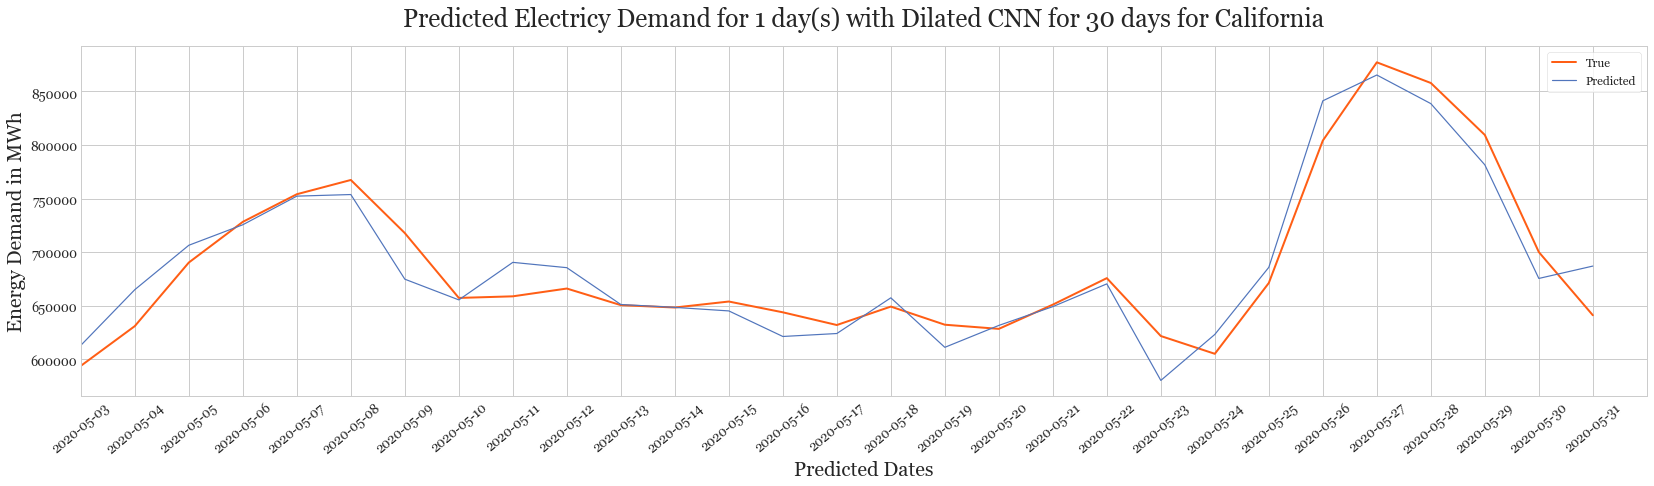

In [666]:
plot_data(X_in[-100:-70],dicnn_predicted_cali,df[-100:-70].index, 'California', 'Dilated CNN',days=30, ax_var=1)

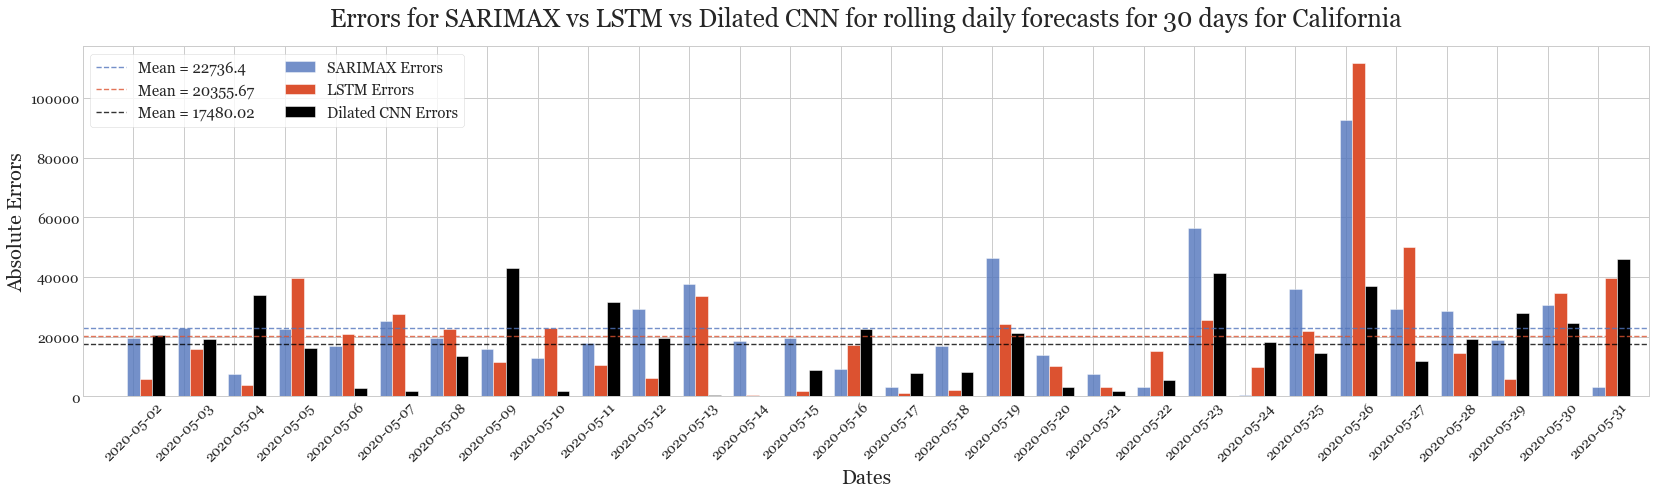

In [618]:
dates = df[-100:-70].index
barWidth = 0.25
r1 = np.arange(len(dates))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
               

fig = plt.figure(figsize=(25,6))

plt.title(f'Errors for SARIMAX vs LSTM vs Dilated CNN for rolling daily forecasts for 30 days for California',fontsize=25, pad=20)  
plt.bar(r1, cali_LSTM_forecast_errors, barWidth, color='#5175bc',alpha=0.8, label=f'SARIMAX Errors')
plt.bar(r2,  cali_arima_errors, barWidth,color='#DC5230', label=f'LSTM Errors' )
plt.bar(r3, dicnn_errors_cali, barWidth,color='black', label=f'Dilated CNN Errors' )
                            
    
    
_ = plt.xticks(indices, [dates[i].strftime('%Y-%m-%d') for i in range(len(dates))], rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Absolute Errors', fontsize=20)
plt.xlabel('Dates', fontsize=20)
_ = plt.xlim(-1,30)
plt.axhline(y=np.mean(cali_LSTM_forecast_errors), color='#5175bc',alpha=0.8, lw=1.4, linestyle='--',  label =f'Mean = {np.round(np.mean(cali_LSTM_forecast_errors),2)}')
plt.axhline(y=np.mean(cali_arima_errors), color='#DC5230',alpha=0.8, lw=1.4, linestyle='--', label=f'Mean = {np.round(np.mean(cali_arima_errors),2)}')
#plt.axhline(y=np.mean(cali_LSTM_forecast_errors), color='#5175bc', alpha=0.5, lw=1.4, linestyle='--', label =f'Mean = {np.round(np.mean(cali_LSTM_forecast_errors),2)}')
plt.axhline(y=np.mean(dicnn_errors_cali), color='black', alpha=0.8, lw=1.4, linestyle='--', label =f'Mean = {np.round(np.mean(dicnn_errors_cali),2)}')

plt.legend(fontsize=15,ncol=2)

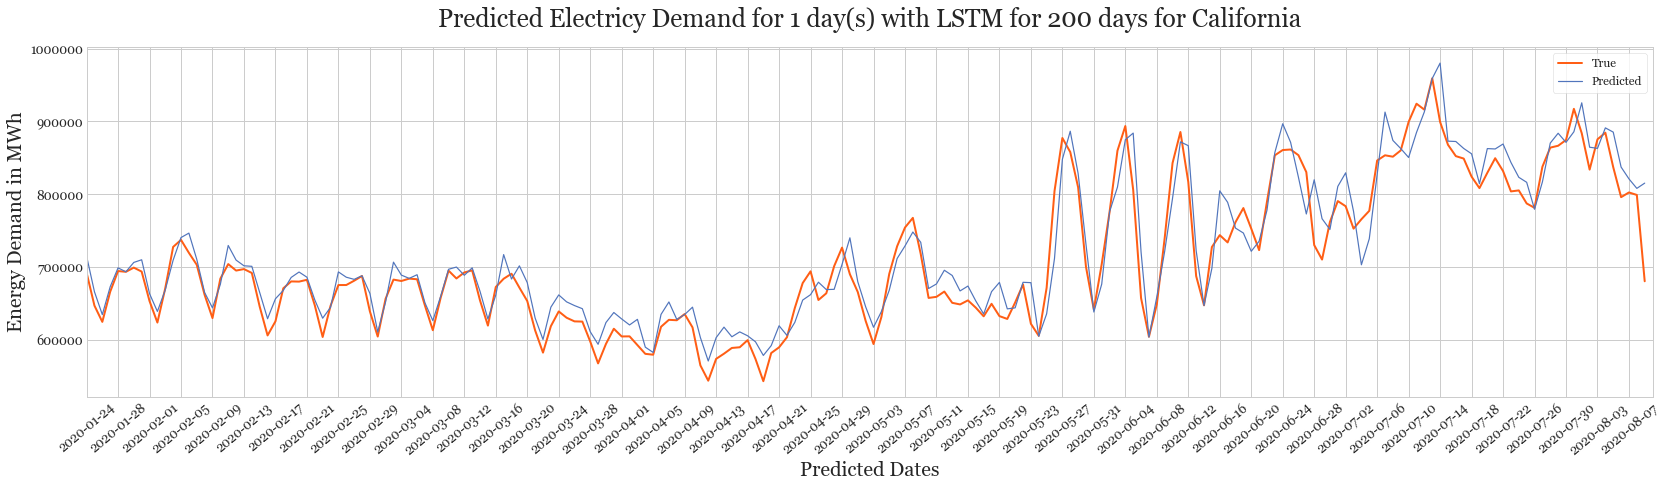

In [381]:
plot_data(X_in[-n_predict:],cali_predictions,df[-200:].index, 'California')

## Trying TBATS

In [44]:
from tbats import TBATS
import numpy as np

# required on windows for multi-processing,
# see https://docs.python.org/2/library/multiprocessing.html#windows

np.random.seed(2342)
y = df.Consumption.values[:-30]
test = df.Consumption.values[-30:]
# Create estimator
estimator = TBATS(seasonal_periods=[7, 365.5, 150])

# Fit model
fitted_model = estimator.fit(y)

y_forecasted = fitted_model.forecast(steps=30)

# Summarize fitted model

print(fitted_model.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [  7.  150.  365.5]
Seasonal harmonics [3 1 5]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 1.462346
Trend (Beta): -0.348928
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-6.99405745e-07 -2.30537305e-07 -1.22491324e-06  3.18345651e-06
  5.69552429e-07 -9.68545606e-07]
AR coefficients []
MA coefficients []
Seed vector [ 7.35753114e+05 -6.55386427e+03  3.42260433e+04 -1.14689177e+04
  1.24482016e+03  1.43260433e+04 -1.11762420e+04  4.02741466e+03
 -7.15007342e+03  1.01117934e+03  7.16932850e+04  2.77553973e+04
 -1.08761892e+04 -3.13998322e+03 -4.99344292e+01  7.66217389e+04
  5.18045575e+04  1.31447805e+04  9.35669045e+02  4.46342100e+03]

AIC 51078.466512


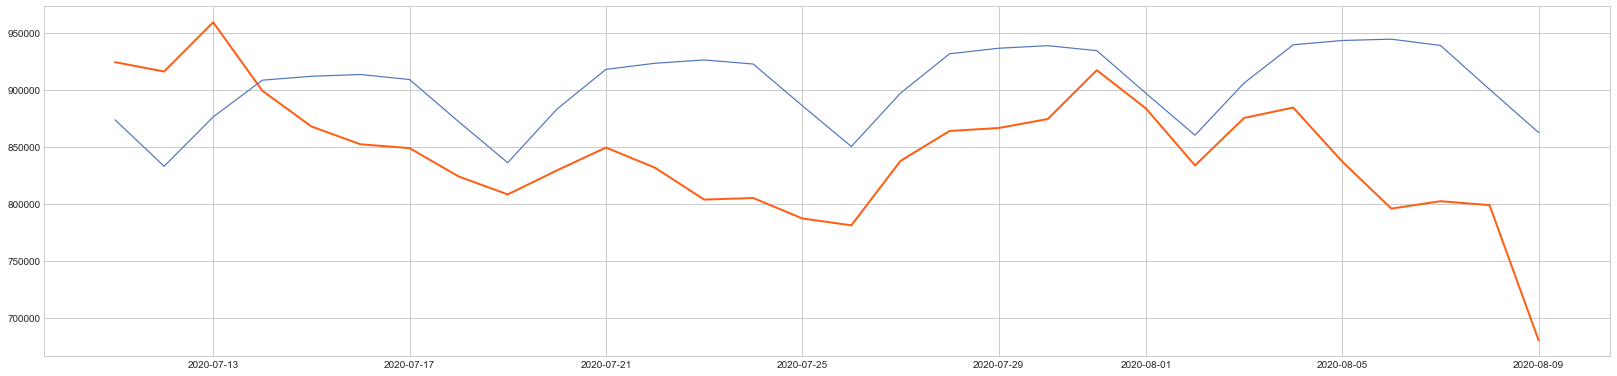

In [89]:
plot_data(test,y_forecasted,df[-30:].index)

In [521]:
predicted = evaluate_timeseries(df.Consumption[:-100], 31, df.Consumption[-100:-70] )



Model with input size (None, 1766, 1), output size (None, 1766, 1)
Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 1766, 1)      0                                            
__________________________________________________________________________________________________
conv1d_793 (Conv1D)             (None, 1766, 32)     64          input_37[0][0]                   
__________________________________________________________________________________________________
activation_289 (Activation)     (None, 1766, 32)     0           conv1d_793[0][0]                 
__________________________________________________________________________________________________
conv1d_795 (Conv1D)             (None, 1766, 1)      32          activation_289[0][0]             
______________________

In [538]:
cnn_predicted_cali = predicted

In [507]:
pred_array

array([[[-3292.11914062],
        [-3325.79882812],
        [-3293.24023438],
        [-3156.74414062],
        [-3144.57177734]]])

In [ ]:
pred_array

In [ ]:
ts2

In [399]:
pred_array[:,0,:]

array([[-1731.84130859]])

In [ ]:
def

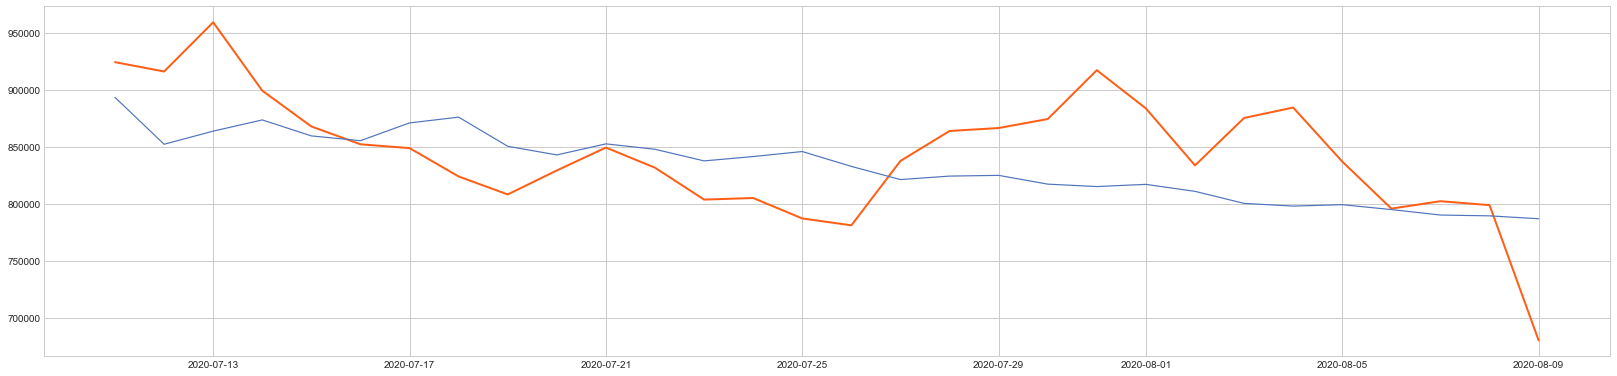

In [90]:
plot_data(df.Consumption[-30:].values,preds,df[-30:].index)